# Importando bibliotecas

In [12]:
import numpy as np
import os
from pandas import read_csv
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import normalize
import csv
import seaborn as sn

## Carregando o dataset

O dataset se encontra no link abaixo, e utilizamos o header para identificar cada um dos 32 atributos.

In [13]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
colunas = ["ID","Diagnóstico",
           "Raio - Média","Textura - Média","Perímetro - Média","Área - Média","Suavidade - Média","Compactação - Média","Concavidade - Média","Pontos Concavos - Média","Simetria - Média","Dimensão Fractal - Média",
           "Raio - Desvio Padrão","Textura - Desvio Padrão","Perímetro - Desvio Padrão","Área - Desvio Padrão","Suavidade - Desvio Padrão","Compactação - Desvio Padrão","Concavidade - Desvio Padrão","Pontos Concavos - Desvio Padrão","Simetria - Desvio Padrão","Dimensão Fractal - Desvio Padrão",
           "Raio - Máximo","Textura - Máximo","Perímetro - Máximo","Área - Máximo","Suavidade - Máximo","Compactação - Máximo","Concavidade - Máximo","Pontos Concavos - Máximo","Simetria - Máximo","Dimensão Fractal - Máximo"]
path = os.getcwd()
dataset = read_csv(url, names = colunas).replace(['B','M'], [0,1])

print("Shape do dataset:", dataset.shape)
dataset.head(5)

Shape do dataset: (569, 32)


,ID,Diagnóstico,Raio - Média,Textura - Média,Perímetro - Média,Área - Média,Suavidade - Média,Compactação - Média,Concavidade - Média,Pontos Concavos - Média,...,Raio - Máximo,Textura - Máximo,Perímetro - Máximo,Área - Máximo,Suavidade - Máximo,Compactação - Máximo,Concavidade - Máximo,Pontos Concavos - Máximo,Simetria - Máximo,Dimensão Fractal - Máximo
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [14]:
array = dataset.values

X = array[:, 2:]
y = array[: , 1]

X = normalize(X, 'max', axis=0)

## Funções Complementares

In [15]:
#Cria todos os classificadores e seus parâmetros diferentes (diferentes quantidades de vizinhos no KNN, por exemplo).
def create_classifiers():
    
    classifiers = {}
    parameters = {}
    names = {}
        
    # KNN
    neighbors = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    classifiers["knn"] = list()
    parameters["knn"] = list()
    names["knn"] = "K-Nearest Neighbors"
    for k in neighbors:
        classifiers["knn"].append(KNeighborsClassifier(n_neighbors=k))
        parameters["knn"].append(k)

    # SVC
    c = [0.1, 1, 5, 10, 15, 20, 25, 30, 40, 50]
    classifiers["svc"] = list()
    parameters["svc"] = list()
    names["svc"] = "Linear Support Vector"
    for Cval in c:
        classifiers["svc"].append(LinearSVC(random_state=42, C=Cval, max_iter=10000))
        parameters["svc"].append(Cval)

    # DT
    max_f = ['sqrt', 'log2', 'auto', None]
    classifiers["dt"] = list()
    parameters["dt"] = list()
    names["dt"] = "Decision Tree"
    for maxf in max_f:
        classifiers["dt"].append(DecisionTreeClassifier(random_state=42, max_features=maxf))
        parameters["dt"].append(maxf)

    # MLP
    layers = [5, 10, 30, 50, 75, 100, 150]
    classifiers["mlp"] = list()
    parameters["mlp"] = list()
    names["mlp"] = "Multi-Layer Perceptron"
    for lay in layers:
        classifiers["mlp"].append(MLPClassifier(random_state=42, hidden_layer_sizes=(lay,), max_iter=1000))
        parameters["mlp"].append(lay)
    
    return classifiers, names, parameters

In [16]:
#Soma duas matrizes de confusão 2 por 2
def sum_confusion_matrix(conf_matrix, conf_matrix_sum):

    for i in range(0,2):
        for j in range(0,2):
            conf_matrix_sum[i][j] = conf_matrix_sum[i][j] + conf_matrix[i][j]

    return conf_matrix_sum

In [23]:
#Plota um gráfico que mostra a precisão, sensibilidade e o fscore do classificador
def plot (title, precision, recall, fscore, key):
    fig = plt.figure()
    x = np.array(range(len(parameters[key])))
    y = np.array(precision)
    
    if "knn" in key:
        param = 'Neighbors'
    
    elif "svc" in key:
        param = 'C value'
        
    elif "dt" in key:
        param = 'Features'
    
    elif "mlp" in key:
        param = 'Layers'
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    my_xticks = ["None" if x is None else x for x in parameters[key]]
    plt.xticks(x, my_xticks)
    plt.ylim(0.9, 1.0)
    
    plt.title(title)
    plt.xlabel(param)
    plt.ylabel("Score")
    
    ax1.scatter(x, precision, label="Precision")
    ax1.scatter(x, recall, label="Recall")
    ax1.scatter(x, fscore, label="FScore")
    
    plt.legend(loc='upper right');
    plt.show()
    return fig

In [18]:
def create_csv(path, name_csvfile):
    
    if not os.path.exists(os.path.join(path, 'csvfiles')):
        os.makedirs(os.path.join(path, 'csvfiles'))
        

    if not os.path.exists(os.path.join(path, 'csvfiles', name_csvfile + '.csv')):
        with open(os.path.join(path, 'csvfiles', name_csvfile + '.csv'), 'w', newline='') as csvf:
            writer = csv.writer(csvf, delimiter=',')
            writer.writerow(['sep=,'])
            writer.writerow(['Classifier', 'Parameter', 'Precision', 'Recall', 'Fscore', 'Confusion Matrix'])

In [19]:
def appendrow_csv(path, name_csvfile, cl, precision, recall, fscore, parameter, conf_matrix_sum):
    
    if os.path.exists(os.path.join(path, 'csvfiles', name_csvfile + '.csv')):
        with open(os.path.join(path, 'csvfiles', name_csvfile + '.csv'), 'a', newline='') as csvf:

            writer = csv.writer(csvf, delimiter=',')
            writer.writerow([cl, str(parameter), round(precision, 4), round(recall, 4), round(fscore, 4), conf_matrix_sum[0]])
            writer.writerow(['', '', '', '', '' , conf_matrix_sum[1]])
            writer.writerow([''])

In [24]:
#Plota a matriz de confusão do classificador em tons de azul
def plot_confusion_matrix (title, data):
    fig = plt.figure()
    df_cm = pd.DataFrame(data, index = [i for i in "BM"], columns = [i for i in "BM"])
    plt.title(title)
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.show()
    return fig

## Bloco principal

In [21]:
classifiers, names, parameters = create_classifiers()
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
name_csvfile = 'results_all_experiments'
create_csv(path, name_csvfile)

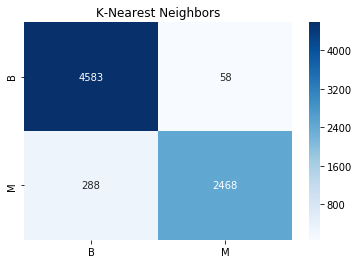

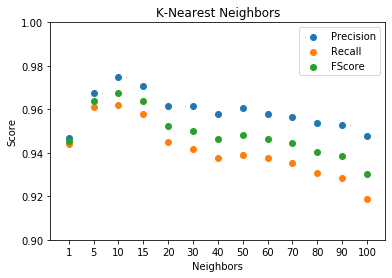

Precision mean using knn =  0.9592
Recall mean using knn =  0.9415
F-score mean using knn =  0.949
Precision std using knn =  0.008
Recall std using knn =  0.0123
F-score std using knn =  0.0104
Best f-score using knn =  0.9676




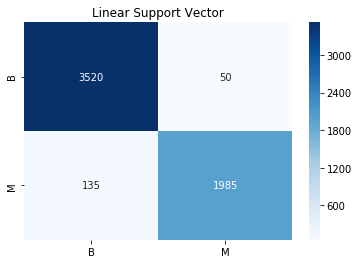

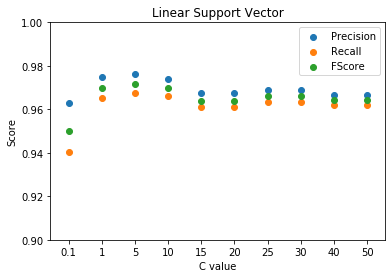

Precision mean using svc =  0.9694
Recall mean using svc =  0.9612
F-score mean using svc =  0.9649
Precision std using svc =  0.004
Recall std using svc =  0.0072
F-score std using svc =  0.0056
Best f-score using svc =  0.9716




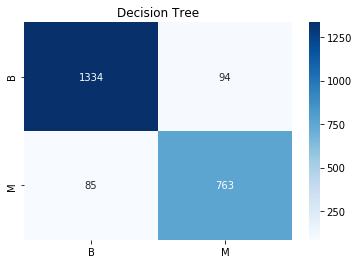

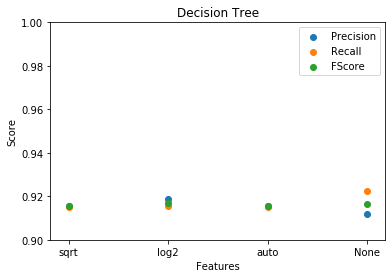

Precision mean using dt =  0.9155
Recall mean using dt =  0.917
F-score mean using dt =  0.9161
Precision std using dt =  0.0024
Recall std using dt =  0.0033
F-score std using dt =  0.0007
Best f-score using dt =  0.917




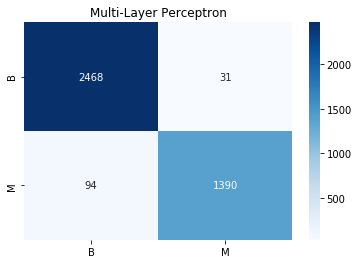

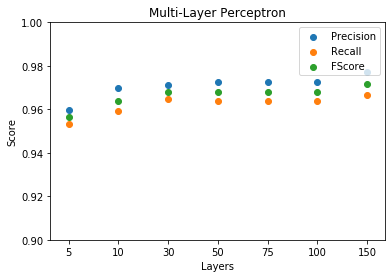

Precision mean using mlp =  0.9708
Recall mean using mlp =  0.9621
F-score mean using mlp =  0.9661
Precision std using mlp =  0.0049
Recall std using mlp =  0.0041
F-score std using mlp =  0.0044
Best f-score using mlp =  0.9715




In [22]:
for key in classifiers:
    precision_list = list()
    recall_list = list()
    fscore_list = list()
    conf_matrix_sum = np.zeros((2,2), dtype=np.uint16)
    
    for i in range(len(classifiers[key])):
        clf = classifiers[key][i]
        y_test_kfold = np.asarray([], dtype=np.uint8)
        y_pred_kfold = np.asarray([], dtype=np.uint8)

        for train_index, test_index in kf.split(X, y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            conf_matrix = confusion_matrix(y_test, y_pred)
            y_test_kfold = np.concatenate((y_test_kfold, y_test))
            y_pred_kfold = np.concatenate((y_pred_kfold, y_pred))
            conf_matrix_sum = sum_confusion_matrix(conf_matrix, conf_matrix_sum)


        
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test_kfold, y_pred_kfold, average='macro')
        precision_list.append(precision)
        recall_list.append(recall)
        fscore_list.append(fscore)
        appendrow_csv(path, name_csvfile, names[key], precision, recall, fscore, parameters[key][i], conf_matrix_sum)
        
    plt_cfm = plot_confusion_matrix(names[key], conf_matrix_sum)
    plt_cfm.savefig(os.path.join("Imagens",key+"_mat.png"))
    plt_graph = plot(names[key], precision_list, recall_list, fscore_list, key)
    plt_graph.savefig(os.path.join("Imagens",key+"_graph.png"))
    print('Precision mean using', key + ' = ', round(np.mean(precision_list), 4))
    print('Recall mean using', key + ' = ', round(np.mean(recall_list), 4))
    print('F-score mean using', key + ' = ', round(np.mean(fscore_list), 4))
    print('Precision std using', key + ' = ', round(np.std(precision_list), 4))
    print('Recall std using', key + ' = ', round(np.std(recall_list), 4))
    print('F-score std using', key + ' = ', round(np.std(fscore_list), 4))
    print('Best f-score using', key + ' = ', round(np.amax(fscore_list), 4))
    print('\n====================================================\n')